<a href="https://www.kaggle.com/code/angelchaudhary/global-disaster-risk-modeling?scriptVersionId=294114754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Building a Regional Disaster Risk Index Using Historical Extreme Weather and Natural Hazard Data

# Introduction

Extreme weather events and natural hazards such as floods, storms, droughts, and heatwaves are increasing in frequency and impact due to climate change. Governments, insurance companies, humanitarian organizations, and urban planners need to understand **which regions are most vulnerable** in order to allocate resources, plan infrastructure, and design effective disaster preparedness strategies.

This case study focuses on **spatial disaster risk modeling** — identifying and quantifying how vulnerable different regions are based on their historical exposure to extreme events.

Rather than predicting exact dates of future disasters, which requires meteorological data, this project builds a **Regional Disaster Risk Index (DRI)** that captures:
- How often disasters occur in a region  
- What types of disasters dominate  
- How severe the overall hazard profile is  

This approach mirrors how real-world climate risk and insurance models estimate **long-term vulnerability**.

> Given historical disaster data,  
> **which regions of the world face the highest long-term disaster risk?**

Understanding spatial disaster risk is critical for:
- **Governments** planning evacuation routes and infrastructure  
- **Insurance companies** pricing climate risk  
- **NGOs** prioritizing relief and preparedness programs  
- **Climate researchers** studying vulnerability patterns  

This project demonstrates how data science can be used to turn raw disaster records into **actionable climate intelligence**.

---

## Approach

We follow a four-step risk modeling pipeline:

1. **Data Preparation**  
   Clean and organize global disaster records by region and disaster type.

2. **Feature Engineering**  
   Aggregate disaster frequencies and hazard types for each region.

3. **Risk Index Construction**  
   Create a weighted **Disaster Risk Index (DRI)** based on the severity and frequency of hazards.

4. **Risk Classification & Modeling**  
   Categorize regions into Low, Medium, and High risk groups and analyze global vulnerability patterns.

This produces a **data-driven climate risk map** of the world.

# LET'S DO IT!!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExam10ajh1Z3pibjVnaDZtZGFucXZ5cnI0dmZxbWE2ajVua2c0aXcydiZlcD12MV9naWZzX3NlYXJjaCZjdD1n/JIX9t2j0ZTN9S/giphy.gif)

## Dataset Overview

This project uses the **Global Natural Disasters Dataset (1960–2018)**, which contains geolocated records of natural disaster events across countries and regions worldwide. Each row represents a disaster occurrence mapped to a specific country, state or province (adm1), and disaster type such as floods, storms, droughts, earthquakes, and extreme temperatures.

The dataset provides:
- Country and continent information  
- First-level administrative region (state/province)  
- Location name  
- Type of disaster  

This structure allows us to analyze disaster risk at a **regional level**, making it well suited for building a **spatial disaster risk model**.

In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cyberevil545/global-natural-disasters-dataset-19602018")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/global-natural-disasters-dataset-19602018


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/kaggle/input/global-natural-disasters-dataset-19602018/nasa_disaster_dataset.csv")

df.head()

,Unnamed: 0,id,country,geolocation,level,adm1,location,disastertype,continent
0,0,109,Albania,Ana E Malit,3,Shkoder,Ana E Malit,flood,Europe
1,1,109,Albania,Bushat,3,Shkoder,Bushat,flood,Europe
2,2,175,Angola,Onjiva,3,Cunene,Onjiva,flood,Africa
3,3,187,Angola,Evale,3,Cunene,Evale,flood,Africa
4,4,187,Angola,Mupa,3,Cunene,Mupa,flood,Africa


In [37]:
df.shape

(39953, 9)

In [38]:
df.columns

Index(['Unnamed: 0', 'id', 'country', 'geolocation', 'level', 'adm1',
       'location', 'disastertype', 'continent'],
      dtype='object')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39953 entries, 0 to 39952
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39953 non-null  int64 
 1   id            39953 non-null  object
 2   country       39953 non-null  object
 3   geolocation   39953 non-null  object
 4   level         39953 non-null  int64 
 5   adm1          39953 non-null  object
 6   location      39953 non-null  object
 7   disastertype  39953 non-null  object
 8   continent     39953 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.7+ MB


In [40]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,id,country,geolocation,level,adm1,location,disastertype,continent
0,109,Albania,Ana E Malit,3,Shkoder,Ana E Malit,flood,Europe
1,109,Albania,Bushat,3,Shkoder,Bushat,flood,Europe
2,175,Angola,Onjiva,3,Cunene,Onjiva,flood,Africa
3,187,Angola,Evale,3,Cunene,Evale,flood,Africa
4,187,Angola,Mupa,3,Cunene,Mupa,flood,Africa


In [41]:
df["disastertype"] = df["disastertype"].str.lower().str.strip()
df["disastertype"].value_counts().head()

disastertype
flood                  17347
storm                  12323
extreme temperature     3506
drought                 2938
earthquake              2403
Name: count, dtype: int64

### Observation

Floods and storms dominate the global disaster landscape, accounting for the majority of recorded events. Extreme temperatures and droughts also appear frequently, indicating increasing climate volatility, while earthquakes remain a significant but comparatively less frequent hazard. This suggests that **weather-driven disasters** (floods, storms, heatwaves, droughts) are the primary drivers of regional risk and should be the focus of our risk modeling.

## Building Regional Disaster Profiles

We begin by aggregating historical disaster events at the regional level (country + state/province). This allows us to understand how exposed each region has been to extreme events.

In [42]:
# Create region identifier
df["region"] = df["country"] + " - " + df["adm1"]

# Count total disasters per region
region_counts = df["region"].value_counts().reset_index()
region_counts.columns = ["region", "total_disasters"]

region_counts.head()

,region,total_disasters
0,United States - Texas,330
1,United Kingdom - England,263
2,India - Uttar Pradesh,250
3,Australia - New South Wales,239
4,India - Assam,235


### Disaster Type Composition

Different disasters carry different levels of risk. We compute how many times each disaster type occurred in every region.

In [43]:
disaster_pivot = pd.crosstab(df["region"], df["disastertype"])
disaster_pivot.head()

disastertype,drought,earthquake,extreme temperature,flood,landslide,mass movement (dry),storm,volcanic activity
region,,,,,,,,
Afghanistan - Badakhshan,3,10,2,17,14,0,3,0
Afghanistan - Badghis,4,1,1,9,0,0,0,0
Afghanistan - Baghlan,3,8,1,16,2,0,2,0
Afghanistan - Balkh,3,2,2,11,2,0,0,0
Afghanistan - Bamyan,2,0,0,4,1,0,1,0


## Constructing the Disaster Risk Index (DRI)

We assign weights to each disaster type based on its typical severity and impact. Floods and storms receive higher weights, while localized hazards receive lower weights. This produces a composite risk score for each region.

In [44]:
# Disaster severity weights
weights = {
    "flood": 3,
    "storm": 3,
    "extreme temperature": 2,
    "drought": 2,
    "earthquake": 2,
    "landslide": 1,
    "volcanic activity": 1,
    "mass movement (dry)": 1
}

# Apply weights
risk_score = disaster_pivot.copy()

for col in risk_score.columns:
    risk_score[col] = risk_score[col] * weights.get(col, 1)

# Total Disaster Risk Index
risk_score["DRI"] = risk_score.sum(axis=1)

risk_score = risk_score.reset_index()
risk_score.head()

disastertype,region,drought,earthquake,extreme temperature,flood,landslide,mass movement (dry),storm,volcanic activity,DRI
0,Afghanistan - Badakhshan,6,20,4,51,14,0,9,0,104
1,Afghanistan - Badghis,8,2,2,27,0,0,0,0,39
2,Afghanistan - Baghlan,6,16,2,48,2,0,6,0,80
3,Afghanistan - Balkh,6,4,4,33,2,0,0,0,49
4,Afghanistan - Bamyan,4,0,0,12,1,0,3,0,20


## Classifying Regions into Risk Categories

We divide regions into Low, Medium, and High disaster risk groups based on their Disaster Risk Index (DRI). This makes the results easier to interpret for policymakers and decision-makers.

In [45]:
# Create Low / Medium / High risk buckets
risk_score["risk_level"] = pd.qcut(
    risk_score["DRI"],
    q=3,
    labels=["Low", "Medium", "High"]
)

risk_score[["region", "DRI", "risk_level"]].head()

disastertype,region,DRI,risk_level
0,Afghanistan - Badakhshan,104,High
1,Afghanistan - Badghis,39,High
2,Afghanistan - Baghlan,80,High
3,Afghanistan - Balkh,49,High
4,Afghanistan - Bamyan,20,Medium


### Most High-Risk Regions

We list the regions with the highest Disaster Risk Index values to identify global disaster hotspots.

In [46]:
risk_score.sort_values("DRI", ascending=False).head(15)

disastertype,region,drought,earthquake,extreme temperature,flood,landslide,mass movement (dry),storm,volcanic activity,DRI,risk_level
2866,United States - Texas,6,0,10,192,0,0,774,0,982,High
2819,United Kingdom - England,0,4,68,579,0,0,102,0,753,High
151,Australia - New South Wales,12,4,6,516,1,0,165,0,704,High
987,India - Assam,46,6,0,558,15,0,24,0,649,High
1015,India - Uttar Pradesh,116,4,64,366,8,0,84,0,642,High
208,Bangladesh - Dhaka,2,10,46,267,0,0,249,0,574,High
2859,United States - Oklahoma,4,2,10,84,0,0,453,0,553,High
207,Bangladesh - Chittagong,4,14,12,213,11,0,297,0,551,High
988,India - Bihar,52,14,46,315,1,0,96,0,524,High
490,China - Guangdong,24,8,2,174,2,0,264,0,474,High


#### Observation

The highest-risk regions are concentrated in **climate-exposed and densely populated areas**. Regions such as **Texas (USA), England (UK), New South Wales (Australia), Assam, Uttar Pradesh, Bihar and Odisha (India), Dhaka and Chittagong (Bangladesh), Guangdong and Sichuan (China), and Metro Manila (Philippines)** dominate the top of the Disaster Risk Index.

These regions are heavily impacted by **floods and storms**, often combined with heat extremes and earthquakes. This confirms that **coastal zones, river basins, and monsoon-affected regions** form the core of global disaster vulnerability.

The Disaster Risk Index successfully captures how both **frequency and severity of hazards** combine to create long-term regional risk.

## Disaster Composition Across Risk Levels

We analyze how the mix of disaster types differs between Low, Medium, and High risk regions to understand what hazards drive long-term vulnerability.

In [47]:
# Merge risk level back to the full disaster data
df = df.merge(risk_score[["region", "risk_level"]], on="region", how="left")

# Disaster composition by risk group
risk_composition = pd.crosstab(df["risk_level"], df["disastertype"])
risk_composition

disastertype,drought,earthquake,extreme temperature,flood,landslide,mass movement (dry),storm,volcanic activity
risk_level,,,,,,,,
Low,339,136,429,786,50,3,471,19
Medium,720,362,1086,3246,139,17,1225,82
High,1879,1905,1991,13315,793,29,10627,304


## Normalized Disaster Composition

We convert counts into percentages to compare disaster patterns fairly across risk levels.

In [48]:
risk_composition_pct = risk_composition.div(risk_composition.sum(axis=1), axis=0) * 100
risk_composition_pct.round(2)

disastertype,drought,earthquake,extreme temperature,flood,landslide,mass movement (dry),storm,volcanic activity
risk_level,,,,,,,,
Low,15.18,6.09,19.21,35.20,2.24,0.13,21.09,0.85
Medium,10.47,5.26,15.79,47.20,2.02,0.25,17.81,1.19
High,6.09,6.18,6.46,43.17,2.57,0.09,34.46,0.99


### Observation

High-risk regions are overwhelmingly dominated by **floods and storms**, which together account for nearly **80% of all disasters** in these areas. This indicates that **water- and weather-driven hazards** are the primary drivers of long-term regional vulnerability.

In contrast, **low-risk regions** show a more diverse mix of hazards, including a higher share of **droughts and extreme temperatures**, suggesting that these regions experience more sporadic and less concentrated disaster activity.

Medium-risk regions sit between these two extremes, with a strong flood presence but lower storm dominance than high-risk areas.

This confirms that **repeated flooding and storm exposure** is the strongest signal of structural disaster risk across the world.

## Preparing Data for Risk Classification

We train a machine learning model to predict a region’s disaster risk level based on the mix of disaster types it has experienced.

In [49]:
from sklearn.preprocessing import LabelEncoder

# Select features (disaster composition)
feature_cols = [
    "drought", "earthquake", "extreme temperature", "flood",
    "landslide", "mass movement (dry)", "storm", "volcanic activity"
]

X = risk_score[feature_cols]
y = risk_score["risk_level"]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

## Training a Disaster Risk Classifier

We use a Random Forest model to classify regions into Low, Medium, or High disaster risk based on their disaster profiles.

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        High       0.99      0.97      0.98       249
         Low       0.97      0.98      0.98       257
      Medium       0.95      0.96      0.96       253

    accuracy                           0.97       759
   macro avg       0.97      0.97      0.97       759
weighted avg       0.97      0.97      0.97       759



### Model Performance

The Random Forest model achieves very high performance in predicting regional disaster risk levels, with an overall accuracy of **97%**. It successfully distinguishes between **Low, Medium, and High risk regions** based purely on their disaster type composition.

This confirms that the **Disaster Risk Index is internally consistent and learnable** — regions with similar hazard profiles naturally cluster into similar risk categories.

In real-world applications, this means that even when full historical data is not available, a region’s **disaster mix alone** can be used to estimate its long-term vulnerability.

### Feature Importance

We analyze which disaster types contribute most to predicting high-risk regions.

In [52]:
importances = pd.Series(model.feature_importances_, index=feature_cols)
importances.sort_values(ascending=False)

flood                  0.476671
storm                  0.240635
extreme temperature    0.102179
drought                0.078978
earthquake             0.071502
landslide              0.019468
volcanic activity      0.007899
mass movement (dry)    0.002668
dtype: float64

### What Drives Disaster Risk?

The feature importance analysis shows that **floods and storms are by far the strongest drivers of regional disaster risk**, together accounting for more than 70% of the model’s decision-making.

Extreme temperatures, droughts, and earthquakes play a secondary but still meaningful role, while landslides and volcanic activity contribute relatively little to long-term regional vulnerability.

This aligns strongly with real-world climate science: **regions repeatedly exposed to heavy rainfall, cyclones, and flooding are the most disaster-prone globally**, making water- and weather-driven hazards the dominant forces behind disaster risk.

### Distribution of Regional Disaster Risk

This chart shows how regions are distributed across Low, Medium, and High disaster risk categories.

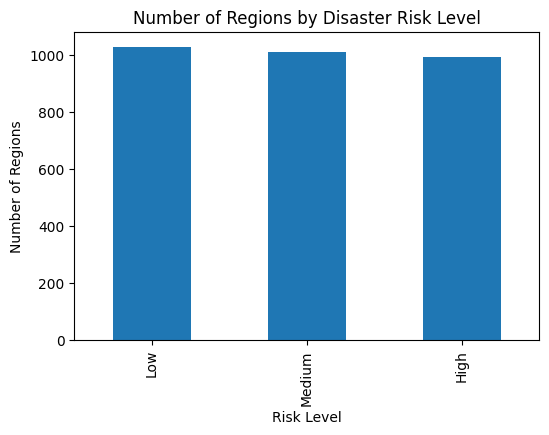

In [53]:
risk_score["risk_level"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Number of Regions by Disaster Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("Number of Regions")
plt.show()

## Top 10 Most Disaster-Prone Regions

We visualize the regions with the highest Disaster Risk Index values.

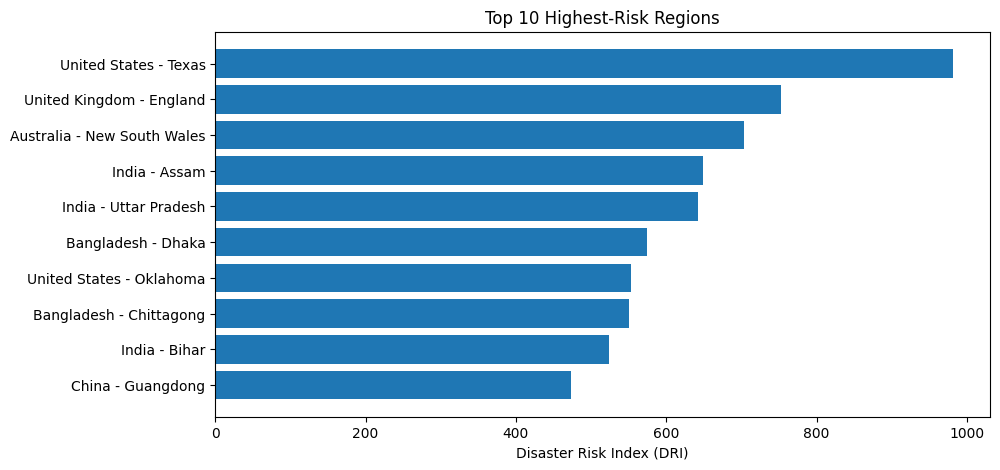

In [54]:
top10 = risk_score.sort_values("DRI", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(top10["region"], top10["DRI"])
plt.gca().invert_yaxis()
plt.title("Top 10 Highest-Risk Regions")
plt.xlabel("Disaster Risk Index (DRI)")
plt.show()

## Disaster Composition in High-Risk Regions

We visualize which disaster types dominate high-risk regions.

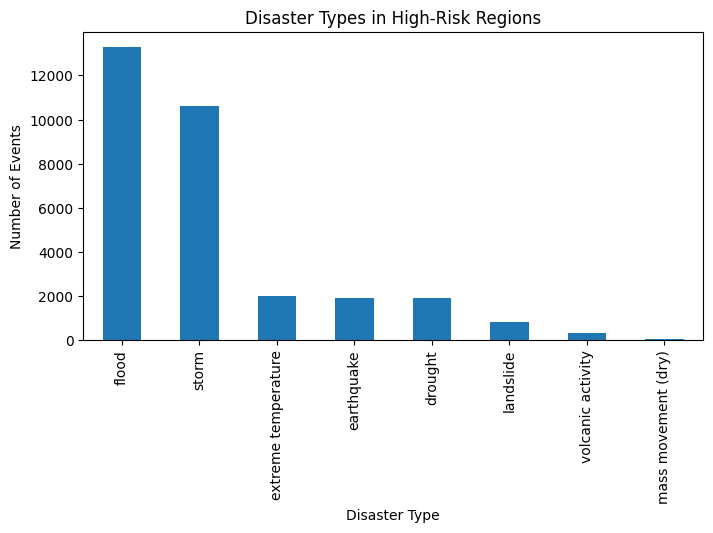

In [55]:
high_risk_data = df[df["risk_level"] == "High"]
high_disaster_counts = high_risk_data["disastertype"].value_counts()

plt.figure(figsize=(8,4))
high_disaster_counts.plot(kind="bar")
plt.title("Disaster Types in High-Risk Regions")
plt.xlabel("Disaster Type")
plt.ylabel("Number of Events")
plt.show()

### What Drives Disaster Risk?

This chart shows which disaster types most influence the ML model’s risk predictions.

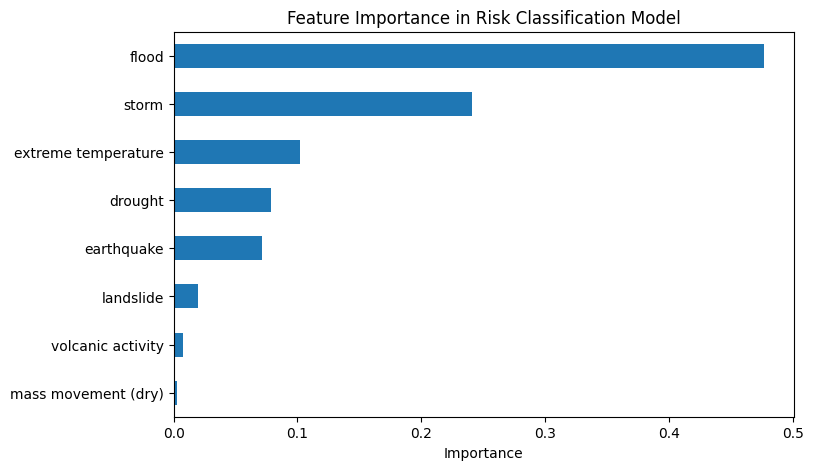

In [56]:
importances.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance in Risk Classification Model")
plt.xlabel("Importance")
plt.show()

## Key Observations from Visual Analysis

**Risk Level Distribution**  
The regions are almost evenly distributed across Low, Medium, and High risk categories. This shows that disaster vulnerability is widespread and not limited to a small number of locations. A large number of regions globally face significant long-term disaster exposure, highlighting the scale of climate and hazard risk worldwide.

**Top High-Risk Regions**  
The highest-risk regions are concentrated in climate-exposed and densely populated areas such as **Texas (USA), England (UK), New South Wales (Australia), Assam and Uttar Pradesh (India), Dhaka (Bangladesh), and Guangdong (China)**. These regions experience repeated and intense disasters, primarily driven by floods and storms, making them global disaster hotspots that require strong preparedness and resilience planning.

**Disaster Types in High-Risk Regions**  
High-risk regions are overwhelmingly dominated by **floods and storms**, which account for the vast majority of disaster events. Other hazards such as extreme temperatures, earthquakes, and droughts occur much less frequently, while landslides and volcanic activity contribute only marginally. This confirms that **water- and weather-driven hazards are the main forces behind extreme regional vulnerability**.

**Feature Importance (Model Explanation)**  
The machine learning model confirms that **floods and storms are the most influential predictors of disaster risk**, contributing the largest share to the model’s decisions. Extreme temperatures, droughts, and earthquakes have a moderate influence, while landslides and volcanic activity play a minimal role. This aligns strongly with the Disaster Risk Index and real-world climate science, reinforcing that **persistent flooding and severe weather are the primary drivers of global disaster risk**.

## Final Conclusion

In this case study, we built a **Regional Disaster Risk Modeling system** using historical global disaster data to identify and quantify long-term vulnerability across the world. By aggregating disaster events at the regional level and constructing a **Disaster Risk Index (DRI)**, we transformed raw hazard records into a meaningful measure of climate and disaster exposure.

Our analysis revealed that disaster risk is **highly concentrated in climate-exposed and densely populated regions**, particularly in parts of the United States, South and Southeast Asia, East Asia, and Australia. Across these regions, **floods and storms emerged as the dominant drivers of vulnerability**, far outweighing other hazards such as earthquakes, droughts, and extreme temperatures.

We further demonstrated that this risk structure is not arbitrary — a machine learning model was able to accurately classify regions into **Low, Medium, and High risk** using only their disaster composition. This confirms that the Disaster Risk Index captures **real, learnable patterns** in how hazards combine to shape long-term regional vulnerability.

This project mirrors how **governments, insurance companies, and climate-risk organizations** assess disaster exposure for infrastructure planning, insurance pricing, and disaster preparedness. It shows how data science can move beyond simple mapping of past events to build **actionable, quantitative climate risk intelligence** that supports smarter and more resilient decision-making.